In [1]:
from pathlib import Path

from IPython.display import Markdown as md

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn3
import pandas as pd
import seaborn as sns

import numpy as np

from tracking_grants import references_f, articles_f, wos_f, altmetric_f
from tracking_grants import tool_name, email, ncbi_api_key



In [118]:
from tqdm.auto import tqdm
import requests
from ratelimit import limits, sleep_and_retry
import re

tqdm.pandas()

from datetime import datetime

In [ ]:
# Load references
refs = pd.read_csv(references_f, index_col="reference_id")

In [66]:
# Load matched articles
articles = pd.read_csv(articles_f)
articles.DOI = articles.DOI.str.lower()

In [108]:
class ClinicalTrials():
    def __init__(self, fields):
        self.baseurl = "https://clinicaltrials.gov/api/query/study_fields"
        self.fields = fields
        self.params = {
            "fields": ",".join(self.fields),
            "min_rnk": 1,
            "max_rnk": None,
            "fmt": "json"
        }
        
    def query_trials(self, pmid):
        params = self.params
        params['expr'] = f"{pmid}[PUBMED-IDS]"
        
        try:
            r =  requests.get(self.baseurl, params=params)
            if r.status_code == 200:
                resp = r.json()['StudyFieldsResponse']
                if resp['NStudiesFound'] > 0:
                    return resp['StudyFields']
                else:
                    return None
            else:
                return None
        except Exception as e:
            return e

In [127]:
fields = ["NCTId", "BriefTitle", "Condition", "OverallStatus", "Phase"]
ct = ClinicalTrials(fields)

clinicaltrials = pd.DataFrame(columns = ['doi', 'pmid'] + fields + ['ts'])

df = articles

dois = df.DOI.tolist()
pmids = df.pmid.tolist()

for doi, pmid in tqdm(zip(dois, pmids), total=len(dois)):
    if pmid:
        ts = datetime.now().isoformat()
        trials = ct.query_trials(pmid)
        if trials:
            for t in trials:
                row = [doi, pmid]
                for f in fields:
                    if f in t:
                        row.append(t[f])
                    else:
                        row.append(None)
                row.append(ts)
                
                clinicaltrials.loc[len(clinicaltrials)+1] = row

In [129]:
clinicaltrials.to_csv("clinicaltrials.csv")

In [138]:
for c in ['NCTId', 'BriefTitle', 'Condition', 'OverallStatus', 'Phase']:
    clinicaltrials[c] = clinicaltrials[c].map(lambda x: x[0] if len(x)==1 else x)

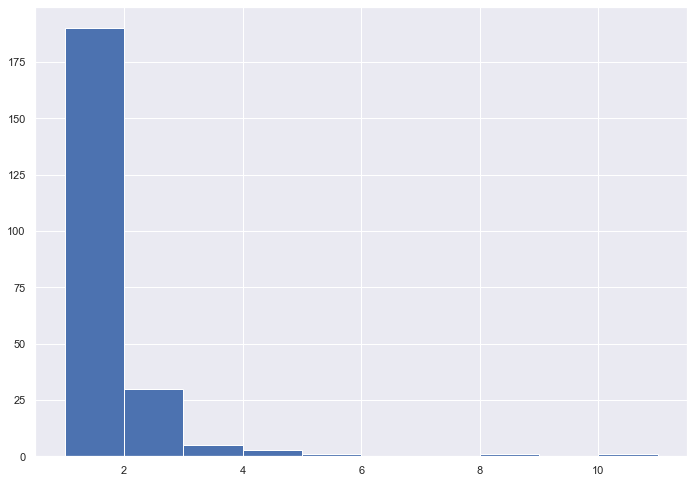

In [132]:
clinicaltrials.doi.value_counts().hist()

In [184]:
columns = ['doi', 'PMID', 'n_trials']
parse_cols = ['NCTId', 'OverallStatus', 'Phase', 'BriefTitle', 'Condition']

df = pd.DataFrame(columns=columns+parse_cols)

for r in results:
    if r['StudyFieldsResponse']['NStudiesFound'] > 0:
        doi = r['doi']
        pmid = r['StudyFieldsResponse']['Expression'].split("[")[0]
        n_trials = r['StudyFieldsResponse']['NStudiesFound']
        for _ in r['StudyFieldsResponse']['StudyFields']:
            row = []
            for pc in parse_cols:
                if pc in _:
                    if len(_[pc]) > 0:
                        x = _[pc][0]
                    else:
                        x = None
                    row.append(x)
            df.loc[len(df)+1] = [doi, pmid, n_trials] + row

Example article with complete clinical trials:

- DOI: https://doi.org/10.1126/science.1168175
- Landing page: https://science.sciencemag.org/content/324/5928/787
- PMID: https://pubmed.ncbi.nlm.nih.gov/19359544/
- Available clinical trials (https://clinicaltrials.gov/search/term=19359544%20%5BPUBMED-IDS%5D):
    - Phase 1: https://clinicaltrials.gov/ct2/show/record/NCT03829930?term=19359544+%5BPUBMED-IDS%5D&draw=2&rank=2
    - Phase 2: https://clinicaltrials.gov/ct2/show/record/NCT03196388?term=19359544+%5BPUBMED-IDS%5D&draw=2&rank=1

Relevant links to play around with clinical trials and pubmedIds

- https://clinicaltrials.gov/ct2/show/NCT01874691
- https://pubmed.ncbi.nlm.nih.gov/20031882/
- https://clinicaltrials.gov/search/term=20031882%20%5BPUBMED-IDS%5D

In [67]:
baseurl = f"https://clinicaltrials.gov/api/query/full_studies"

pmids = articles.pmid.dropna().astype(int)
for pmid in tqdm(pmids):
    params = {
        "expr": "{}[PUBMED-IDS]",
        "min_rnk": 1,
        "max_rnk": None,
        "fmt": "json"
    }
    pmid = 20031882
    params['expr'] = params['expr'].format(pmid)
    
    r = requests.get(baseurl, params=params)
    print(r.json()['FullStudiesResponse']['NStudiesFound'])
    break

1


In [78]:
r.json()['FullStudiesResponse']['FullStudies'][0]['Study']['ProtocolSection']['ReferencesModule']

{'ReferenceList': {'Reference': [{'ReferencePMID': '20031882',
    'ReferenceType': 'background',
    'ReferenceCitation': 'Peterson ED, Roe MT, Rumsfeld JS, Shaw RE, Brindis RG, Fonarow GC, Cannon CP. A call to ACTION (acute coronary treatment and intervention outcomes network): a national effort to promote timely clinical feedback and support continuous quality improvement for acute myocardial infarction. Circ Cardiovasc Qual Outcomes. 2009 Sep;2(5):491-9. doi: 10.1161/CIRCOUTCOMES.108.847145.'},
   {'ReferencePMID': '31567475',
    'ReferenceType': 'derived',
    'ReferenceCitation': 'Song CX, Fu R, Yang JG, Xu HY, Gao XJ, Wang CY, Zheng Y, Jia SB, Dou KF, Yang YJ; CAMI Registry study group. Angiographic characteristics and in-hospital mortality among patients with ST-segment elevation myocardial infarction presenting without typical chest pain: an analysis of China Acute Myocardial Infarction registry. Chin Med J (Engl). 2019 Oct 5;132(19):2286-2291. doi: 10.1097/CM9.00000000000004